In [19]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models, similarities

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix
from sklearn_crfsuite import metrics

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, GRU
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/all_tagged_aspects_just_aspect_cleaned.csv")
df.head()

,rid,Word,Tag
0,9:1,Uygulamada,O
1,9:1,kartlarda,O
2,9:1,Troy,B-A
3,9:1,kart,O
4,9:1,geçmiyor,O


In [4]:
df.shape

(2288270, 3)

In [5]:
BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 64
EMBEDDING = 20

In [6]:
words = list(set(df['Word'].values))
tags = list(set(df["Tag"].values))

In [7]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

In [8]:
idx2word = {i: w for w, i in word2idx.items()}

In [9]:
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

In [10]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [11]:
sentences = [(list(zip(group['Word'], group['Tag']))) for _, group in df.groupby('rid')]

In [12]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = preprocessing.sequence.pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

In [13]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = preprocessing.sequence.pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

In [15]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

X_train shape: (102164, 64)
X_valid shape: (5378, 64)
X_test shape: (5661, 64)


In [16]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

In [17]:
input_dim = len(word2idx) + 1
embedding_dim = 300

In [20]:
input_layer = Input(shape=(MAX_LEN,))

embeddings = Embedding(input_dim, embedding_dim, input_length=MAX_LEN, mask_zero=True, trainable=True)(input_layer)

output_sequences = Bidirectional(GRU(units=32, return_sequences=True))(embeddings)
output_sequences = Bidirectional(GRU(units=64, return_sequences=True))(output_sequences)
output_sequences = Bidirectional(GRU(units=32, return_sequences=True))(output_sequences)

dense_out = TimeDistributed(Dense(16, activation="relu"))(output_sequences)

mask = Input(shape=(MAX_LEN,), dtype=tf.bool)
crf = CRF(4, name='crf')
predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

model = Model(input_layer, potentials)
model.compile(optimizer=AdamW(weight_decay=0.001), loss= SigmoidFocalCrossEntropy())

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 64, 300)           49641000  
                                                                 
 bidirectional (Bidirectiona  (None, 64, 64)           64128     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 128)          49920     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64, 64)           31104     
 nal)                                                            
                                                             

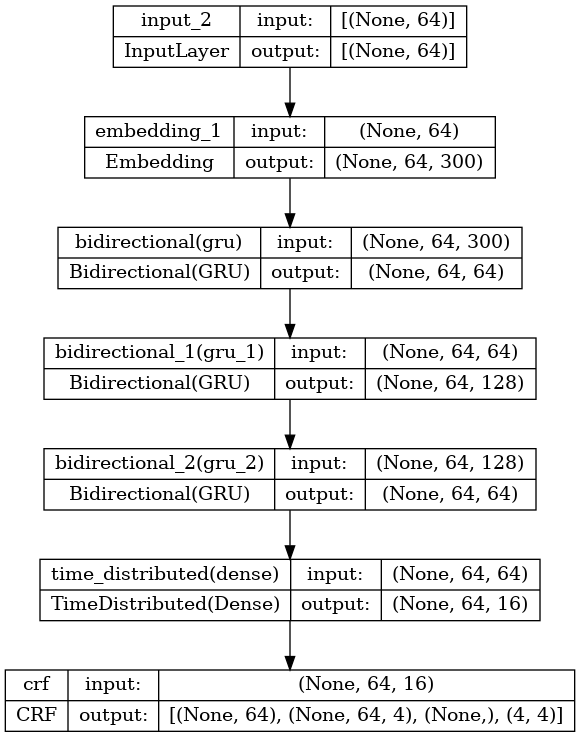

In [22]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True, to_file="./output/bigru_crf_model_plot.png")

In [23]:
model1_train_start = time.time()
model_history = model.fit(
    X_train, 
    y_train, 
    epochs=2, 
    batch_size=128, 
    validation_data=[X_valid, y_valid], 
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=3)]
)
model1_train_time = time.time() - model1_train_start
print(f"Bi-GRU + CRF Train Time = {model1_train_time:.4f}")

Epoch 1/2
799/799 [==============================] - 304s 367ms/step - loss: 0.1454 - val_loss: 0.0298
Epoch 2/2
799/799 [==============================] - 291s 364ms/step - loss: 0.0186 - val_loss: 0.0129
Bi-GRU + CRF Train Time = 595.1420


In [24]:
model1_test_start = time.time()
model_pred_test = model.predict(X_test, verbose=0)
model1_test_time = time.time() - model1_test_start
print(f"Bi-GRU + CRF Test Time = {model1_test_time:.4f}")

Bi-GRU + CRF Test Time = 6.7684


In [25]:
true_labels_train = np.argmax(y_train, axis=-1)
true_labels_test = np.argmax(y_test, axis=-1)

In [26]:
model_pred_train = model.predict(X_train, verbose=0)
model_pred_train = np.argmax(model_pred_train, axis=-1)
model_pred_test = np.argmax(model_pred_test, axis=-1)
model_train_score = metrics.flat_accuracy_score(model_pred_train, true_labels_train)
model_test_score = metrics.flat_accuracy_score(model_pred_test, true_labels_test)
print(f"Bi-GRU + CRF Train Score = {model_train_score * 100:.4f}%")
print(f"Bi-GRU + CRF Test Score = {model_test_score * 100:.4f}%")

Bi-GRU + CRF Train Score = 99.9390%
Bi-GRU + CRF Test Score = 99.9258%


In [27]:
model_precision_score = metrics.flat_precision_score(true_labels_test, model_pred_test, average="macro")
model_f1_score = metrics.flat_f1_score(true_labels_test, model_pred_test, average="macro")
model_recall_score = metrics.flat_recall_score(true_labels_test, model_pred_test, average="macro")
model_accuracy_score = metrics.flat_accuracy_score(true_labels_test, model_pred_test)

print(f"Bi-GRU + CRF Precision Score = {model_precision_score * 100:.4f}%")
print(f"Bi-GRU + CRF F1 Score = {model_f1_score * 100:.4f}%")
print(f"Bi-GRU + CRF Recall Score = {model_recall_score * 100:.4f}%")
print(f"Bi-GRU + CRF Accuracy Score = {model_accuracy_score * 100:.4f}%")

Bi-GRU + CRF Precision Score = 99.2422%
Bi-GRU + CRF F1 Score = 91.2102%
Bi-GRU + CRF Recall Score = 87.1363%
Bi-GRU + CRF Accuracy Score = 99.9258%


In [28]:
print(metrics.flat_classification_report(true_labels_test, model_pred_test, target_names=["PAD", "O", "I-A", "B-A"]))

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00    249405
           O       0.98      0.49      0.66       338
         I-A       1.00      1.00      1.00    104634
         B-A       1.00      0.99      0.99      7927

    accuracy                           1.00    362304
   macro avg       0.99      0.87      0.91    362304
weighted avg       1.00      1.00      1.00    362304



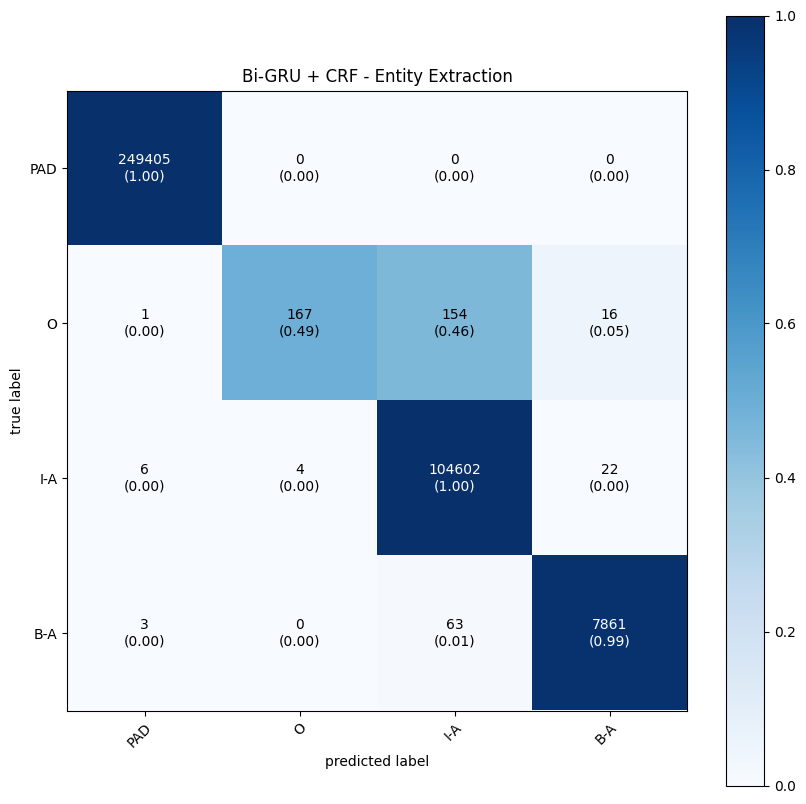

In [29]:
model_cm = confusion_matrix(metrics.flatten(true_labels_test), metrics.flatten(model_pred_test))
fig, ax = plot_confusion_matrix(conf_mat=model_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["PAD", "O", "I-A", "B-A"], figsize=(10, 10))
plt.title("Bi-GRU + CRF - Entity Extraction")
plt.savefig("./output/bigru_crf.png")
plt.show()